# Data augmentation exercise
In this exercise we'll practice data augmentation on images. This includes:
* Translation
* Mirroring
* Zoom
* Rotation

And to make this a bit more challenging we'll also have a bounding box (used often for object detection or image classification with localization) that also will have to be adjusted to fit the augmented image. 

In this exercise I've prepared to use PIL (Python Image Library) but other libraries can be used if you prefer. OpenCV is a good alternative with lots of good tutorials.


In [30]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math


In [31]:
# Load image
path = "cat_in_box.jpg" # Use your own image here if you'd like :) 
image = Image.open(path).rotate(0).resize((150,150)) 

# Define a sample bounding box
bbox = [60, 22, 38, 83]  # Format: [x_min, y_min, width, height]


Lets look at the original image and the bounding box.

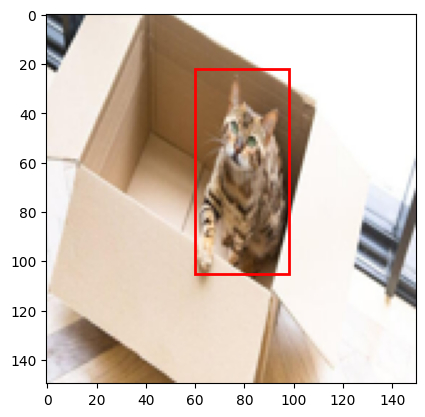

In [32]:
def visualize_image_and_bbox(image, bbox):
    fig, ax = plt.subplots(1)
    ax.imshow(tf.cast(image, tf.uint8))

    # Create a Rectangle patch for the bounding box
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

visualize_image_and_bbox(image, bbox)


# Translation
Always ensure that the augmented bounding box remains within the image boundaries and maintains a valid size and aspect ratio.

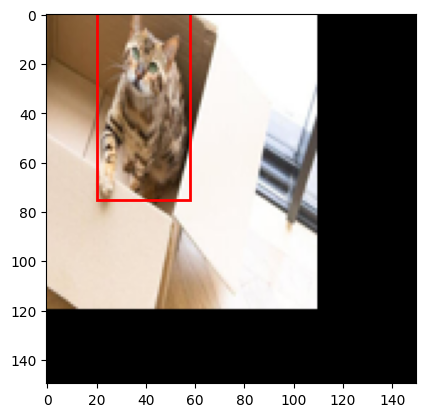

In [33]:
def translate_image_and_bbox(image, bbox, dx, dy):
    # Translate the image
    translated_image = image.transform(
        image.size, Image.AFFINE, (1, 0, dx, 0, 1, dy), resample=Image.BICUBIC, fill=1
    )

    # Adjust the bounding box
    x_min, y_min, width, height = bbox
    new_x_min = x_min - 40
    new_y_min = y_min - 30
    new_width = width
    new_height = height

    translated_bbox = [new_x_min, new_y_min, new_width, new_height]

    return translated_image, translated_bbox


dx, dy = 40, 30  # Translation values
translated_image, translated_bbox = translate_image_and_bbox(image, bbox, dx, dy)
visualize_image_and_bbox(translated_image, translated_bbox)

# Mirroring

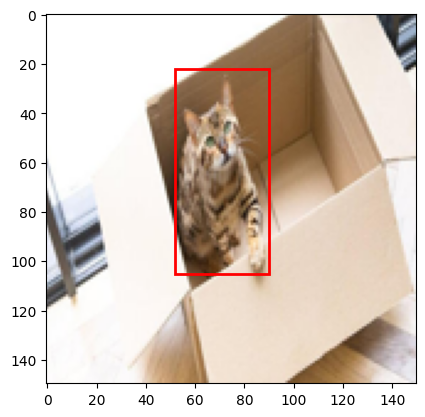

In [34]:
def flip_image_and_bbox(image, bbox):
    # Flip the image
    flipped_image = image.transpose(method=Image.Transpose.FLIP_LEFT_RIGHT)

    # Adjust the bounding box
    x_min, y_min, width, height = bbox

    new_x_min = 150 - x_min-width
    new_y_min = y_min
    new_width = width
    new_height = height
    
    flipped_bbox = [new_x_min, new_y_min, new_width, new_height]

    return flipped_image, flipped_bbox

flipped_box, flipped_bbox = flip_image_and_bbox(image, bbox)
visualize_image_and_bbox(flipped_box, flipped_bbox)

# Zoom (scaling)
To make this easier we're only zooming into the top left corner of the image

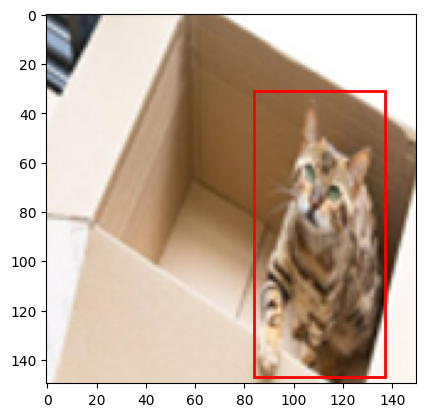

In [35]:
def zoom_scale_crop_image_and_bbox(image, bbox, zoom_factor, crop_size=(150, 150)):
    original_width, original_height = image.size

    # Calculate new dimensions
    new_width = int(original_width * zoom_factor)
    new_height = int(original_height * zoom_factor)

    # Scale the image
    scaled_image = image.resize((new_width, new_height), Image.BICUBIC)

    # Adjust the bounding box
    x_min, y_min, width, height = bbox
    
    new_x_min = x_min*zoom_factor
    new_y_min = y_min*zoom_factor
    new_width = width*zoom_factor
    new_height = height*zoom_factor
    
    scaled_bbox = [new_x_min, new_y_min, new_width, new_height]

    # Crop the scaled image
    cropped_image = scaled_image.crop((0, 0, crop_size[0], crop_size[1]))

    # Ensure the bounding box fits within the cropped dimensions
    cropped_bbox = scaled_bbox

    return cropped_image, cropped_bbox

zoom_factor = 1.4 # Example zoom factor
cropped_image, cropped_bbox = zoom_scale_crop_image_and_bbox(image, bbox, zoom_factor)
visualize_image_and_bbox(cropped_image, cropped_bbox)

# Rotation
This is also a simplified function to keep this to an appropriate level.The rotation function rotates the image and then adjusts the position of the bounding box's center. **The dimensions of the bounding box remain the same.**

The rotation angle is in degrees. Positive values rotate the image counterclockwise.
This approach assumes that the rotation does not cause the bounding box to exceed the image boundaries. For larger angles or bounding boxes near the edge, additional logic is needed to handle these cases.

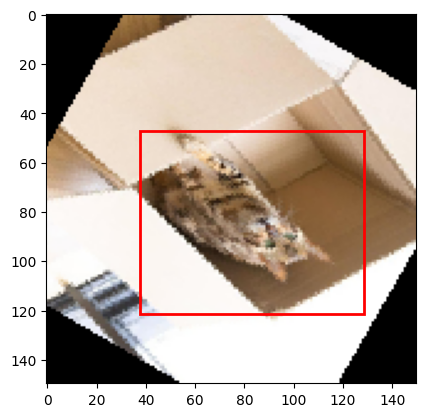

In [36]:
def rotate_point(x, y, angle, ox, oy):
    """Rotate a point counterclockwise by a given angle around a given origin."""
    rad = np.radians(angle)
    qx = ox + np.cos(rad) * (x - ox) - np.sin(rad) * (y - oy)
    qy = oy + np.sin(rad) * (x - ox) + np.cos(rad) * (y - oy)
    return qx, qy

def rotate_image_and_bbox(image, bbox, angle):
    # Center of rotation is the center of the image
    ox, oy = image.width / 2, image.height / 2

    # Coordinates of the bounding box corners
    x_min, y_min, width, height = bbox
    corners = [(x_min, y_min), (x_min + width, y_min), 
               (x_min, y_min + height), (x_min + width, y_min + height)]

    # Rotate the image
    rotated_image = image.rotate(-angle, expand=False)
    
    # Rotate the corners of the bounding box
    rotated_corners = [rotate_point(x, y, angle, ox, oy) for (x, y) in corners]

    # Determine new bounding box (min and max coordinates)
    min_x = min([x for x, y in rotated_corners])
    min_y = min([y for x, y in rotated_corners])
    max_x = max([x for x, y in rotated_corners])
    max_y = max([y for x, y in rotated_corners])

    # New bounding box (x_min, y_min, width, height)
    new_bbox = [min_x, min_y, max_x - min_x, max_y - min_y]

    return rotated_image, new_bbox

rotation_angle = 120  # Rotation angle in degrees
rotated_image, new_bbox = rotate_image_and_bbox(image, bbox, rotation_angle)
visualize_image_and_bbox(rotated_image, new_bbox)

# Generic augmentation
Ok bounding boxes are hard to augment. Let's leave that for now. Instead now create, using the tensorflow preprocessing library, a function which does an random augmentation on an image given a range of allowed values. 
Play around with the ImageDataGenerator https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator


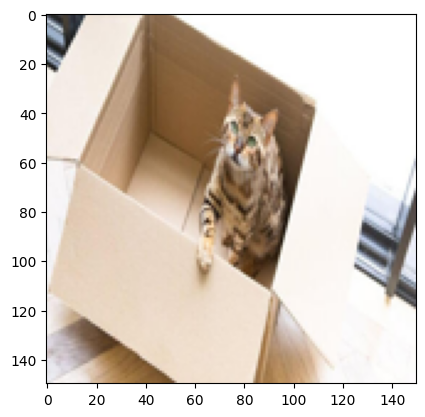

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

datagen = ImageDataGenerator(
    # Fill in your parameters here
)

# Convert the image to a numpy array and add a batch dimension
image_array = img_to_array(image)  # Convert to numpy array
image_array = image_array[tf.newaxis, ...]  # Add the batch dimension

# Apply the transformation.
iterator = datagen.flow(image_array, batch_size=1)
transformed_image = next(iterator)

# plot the image
fig, ax = plt.subplots(1)
ax.imshow(tf.cast(transformed_image[0], tf.uint8))  # Indexing at 0 to get the first image in the batch
plt.show()